# Analysis of baseline differences between ECT and MST treatment groups

## imports

In [104]:
import numpy as np
import scipy.io as sio
import pandas as pd
import h5py as h5

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import corr, ttest, normality, wilcoxon

from sklearn import linear_model
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.linear_model import LinearRegression

---

# 1) MST

## load EEG features

This cell loads the dataframe with the outputs of the spectral parameterization analysis. Features are then averaged over all electrodes. We are averaging over all electrodes because no spectral features of interest show a characteristic, informative spatial topography. Futhermore, model fits <0.8 are dropped due to poor models fits.

In [2]:
# load dataframe of EEG features
eeg_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col = 0)

# Exclude channels flagged as bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# average across ALL electrodes
eeg_df_mean = pd.DataFrame(eeg_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

In [3]:
def compute_abundance(df, feature=''):
    """computes abundance as the number of channels containing an oscillation/total channels
    Parameters
    ----------
    Returns
    -------
    """
    features = ['patient','pre_post','channel', feature+'_cf']
    df_osc = pd.DataFrame(df[features])
    df_osc[f'{feature}_present'] = df_osc[feature+'_cf'].notna()
    ch_osc = df_osc.groupby(['patient', 'pre_post'])[f'{feature}_present'].sum().values
    ch_total = df_osc.groupby(['patient', 'pre_post'])['channel'].count().values
    ch_osc_perc = ch_osc/ch_total
    osc_perc_df = pd.DataFrame(df_osc.groupby(['patient', 'pre_post'], as_index=False)[f'{feature}_present'].sum())
    osc_perc_df[f'ch_{feature}_perc'] = ch_osc_perc
    
    return osc_perc_df

In [4]:
delta_perc_df = compute_abundance(eeg_df_included, feature='delta')
theta_perc_df = compute_abundance(eeg_df_included, feature='theta')
alpha_perc_df = compute_abundance(eeg_df_included, feature='alpha')

In [5]:
# merge percentage dfs
perc_df = pd.merge(theta_perc_df, delta_perc_df, how='left', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_perc_df, how='left', on=['patient', 'pre_post'])

In [6]:
# merge perc with main eeg feature df
eeg_df_mean = pd.merge(eeg_df_mean, perc_df, how='left', on=['patient', 'pre_post'])

## convert EEG features dataframe into better format

The ideal dataframe for our analysis has one line for each patient. EEG features are either pre_feature, post_feature, or d_feature.

In [7]:
# pre eeg features
eeg_pre_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='pre'] 

# post eeg features
eeg_post_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='post'] 

features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent',
            'ch_delta_perc', 'ch_theta_perc', 'ch_alpha_perc']

# difference in eeg features (pre-post)
eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = eeg_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_47718/668889714.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [8]:
eeg_pre_df_mean = eeg_pre_df_mean.rename(columns={c: 'pre_'+c for c in eeg_pre_df_mean.columns if c not in ['patient']})
eeg_post_df_mean = eeg_post_df_mean.rename(columns={c: 'post_'+c for c in eeg_post_df_mean.columns if c not in ['patient']})
eeg_diff_df_mean = eeg_diff_df_mean.rename(columns={c: 'diff_'+c for c in eeg_diff_df_mean.columns if c not in ['patient']})


In [9]:
eeg_pre_post = pd.merge(eeg_pre_df_mean, eeg_post_df_mean, on='patient', how='left')
eeg_pre_post_diff = pd.merge(eeg_pre_post, eeg_diff_df_mean, on='patient', how='left')

In [10]:
eeg_pre_post_diff = eeg_pre_post_diff.drop(labels=['pre_pre_post', 'post_pre_post'], axis='columns')

In [11]:
eeg_pre_post_diff

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_theta_bp,diff_alpha_cf,diff_alpha_bw,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc
0,9,2.005953,1.000000,0.146205,-11.321277,5.350125,1.818249,0.406346,-11.572985,9.112030,...,0.217771,-0.192200,1.119524,-0.033322,0.237228,0.507025,0.345650,0.033333,-0.416667,0.000000
1,10,2.453152,1.000000,0.040532,-12.365095,6.482045,1.017572,0.186566,-12.690452,9.555304,...,0.271554,-0.243517,0.389320,0.133247,0.377337,0.261876,0.025480,0.017857,0.071429,0.125000
2,18,2.749999,1.000000,0.000270,-11.664588,5.256693,1.425727,0.347283,-11.836585,8.734414,...,0.134673,-0.024780,0.562352,0.012112,-0.016471,0.042335,0.115917,0.000000,0.266667,0.000000
3,22,NaN,NaN,NaN,-11.830947,6.542572,2.014467,0.452602,-11.993586,9.135260,...,-0.450002,0.006089,-1.981499,0.285625,-0.103030,-0.369752,-0.184502,0.000000,0.000000,0.000000
4,25,NaN,NaN,NaN,-11.694787,6.619938,1.421509,0.362230,-12.026519,8.687937,...,0.323614,-0.800650,-0.613174,-0.779568,-0.284728,0.466595,0.014182,-0.033898,0.118644,0.000000
5,33,NaN,NaN,NaN,-11.528993,5.631176,1.607905,0.454667,-11.381208,8.937167,...,-0.488498,0.058184,-0.219198,0.204019,0.044466,-0.526216,-0.494473,-0.133333,-0.266667,0.000000
6,35,3.937715,1.000000,0.201216,-11.883628,5.972226,2.172916,0.579893,-11.723036,7.923002,...,-0.371153,-0.089036,0.994337,0.103503,0.007112,-0.224031,-0.138135,0.066667,-0.583333,0.466667
7,46,NaN,NaN,NaN,-11.726602,4.630958,1.658109,0.392234,-11.773041,9.020745,...,-0.025370,-0.023627,-0.105915,0.087367,0.072388,-0.005157,-0.036711,0.000000,-0.116667,0.000000
8,47,3.012010,1.184911,0.202836,-11.998070,5.407184,2.042564,0.173121,-12.393061,8.833356,...,0.344395,-0.626846,0.838933,-0.289977,0.098429,0.266258,0.144388,0.183333,0.033333,0.000000
9,53,2.605767,1.000000,0.055501,-11.787089,6.301462,1.015626,0.313621,-12.095150,9.218807,...,-0.245605,-0.093968,-0.468883,-0.235628,-0.237180,-0.002819,0.032645,-0.016667,0.100000,0.000000


## load clinical features CSV

This cell loads the dataframes with clinical ratings and demographics. These dataframes are then refactored into a single clinical dataframe with the relevant features included.

In [12]:
MST_clinical = pd.read_csv('../saved_files_appeal/mst_files/mst_clinical_data/MST_clinical.csv')
MST_HAMD = pd.read_csv('../saved_files_appeal/mst_files/mst_clinical_data/MST_HAMD.csv')
exp_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col=0)

# rename columns

MST_HAMD = MST_HAMD[['subject', 'TotalBaseline', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                'TotalBaseline': 'pre_HAMD',
                                                                                'TotalPost': 'post_HAMD'})
MST_clinical = MST_clinical[['SubjectID', 'x_OfAcuteTxsReceived']].copy().rename(columns={'SubjectID': 'patient',
                                                                                  'x_OfAcuteTxsReceived': 'n_TxsReceived'})

#merge into single dataframe
all_clinical = pd.merge(MST_HAMD, MST_clinical, on='patient', how='outer')

## note about merging clinical and EEG data

Merge dataframes at an ad-hoc basis for the demands of each regression formula 

In [13]:
mst_clin_eeg_df = pd.merge(eeg_pre_post_diff, all_clinical, on='patient', how='left')

---
# 2) ECT

## load EEG features

This cell loads the dataframe with the outputs of the spectral parameterization analysis. Features are then averaged over all electrodes. We are averaging over all electrodes because no spectral features of interest show a characteristic, informative spatial topography. Futhermore, model fits <0.8 are dropped due to poor models fits.

In [14]:
# load dataframe of EEG features
eeg_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col = 0)

# Exclude channels flagged as bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# average across ALL electrodes
eeg_df_mean = pd.DataFrame(eeg_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

In [15]:
delta_perc_df = compute_abundance(eeg_df_included, feature='delta')
theta_perc_df = compute_abundance(eeg_df_included, feature='theta')
alpha_perc_df = compute_abundance(eeg_df_included, feature='alpha')

In [16]:
# merge percentage dfs
perc_df = pd.merge(theta_perc_df, delta_perc_df, how='left', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_perc_df, how='left', on=['patient', 'pre_post'])

In [17]:
# merge perc with main eeg feature df
eeg_df_mean = pd.merge(eeg_df_mean, perc_df, how='left', on=['patient', 'pre_post'])

## convert EEG features dataframe into better format

The ideal dataframe for our analysis has one line for each patient. EEG features are either pre_feature, post_feature, or d_feature.

In [18]:
# pre eeg features
eeg_pre_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='pre'] 

# post eeg features
eeg_post_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='post'] 

features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent',
            'ch_delta_perc', 'ch_theta_perc', 'ch_alpha_perc']

# difference in eeg features (pre-post)
eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = eeg_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_47718/668889714.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [19]:
eeg_pre_df_mean = eeg_pre_df_mean.rename(columns={c: 'pre_'+c for c in eeg_pre_df_mean.columns if c not in ['patient']})
eeg_post_df_mean = eeg_post_df_mean.rename(columns={c: 'post_'+c for c in eeg_post_df_mean.columns if c not in ['patient']})
eeg_diff_df_mean = eeg_diff_df_mean.rename(columns={c: 'diff_'+c for c in eeg_diff_df_mean.columns if c not in ['patient']})


In [20]:
eeg_pre_post = pd.merge(eeg_pre_df_mean, eeg_post_df_mean, on='patient', how='left')
eeg_pre_post_diff = pd.merge(eeg_pre_post, eeg_diff_df_mean, on='patient', how='left')

In [21]:
eeg_pre_post_diff = eeg_pre_post_diff.drop(labels=['pre_pre_post', 'post_pre_post'], axis='columns')

In [22]:
eeg_pre_post_diff

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_theta_bp,diff_alpha_cf,diff_alpha_bw,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,-1.047483,0.081001,-1.181671,0.275602,-0.286402,-1.257006,-0.921488,-0.283333,-0.283333,0.016667
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,0.160953,0.813720,0.140621,0.476360,0.772309,0.295766,-0.165961,-0.033333,-0.816667,0.000000
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,-1.067190,1.695906,-1.102768,-0.338883,-0.726749,-0.580045,-0.353966,0.116667,-0.283333,0.000000
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,-0.212238,0.028742,-0.080232,0.100156,-0.051523,-0.172336,-0.081453,-0.016667,-0.166667,0.000000
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,-1.106876,1.022782,-2.992160,0.124481,-0.211126,-0.712337,-0.495305,-0.133333,-0.316667,0.000000
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,-0.899623,0.645290,-2.516315,-0.351969,-0.668322,-0.656820,-0.451485,-0.050000,-0.466667,0.133333
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,-0.507658,1.255797,-0.260381,0.767590,0.051426,-0.437258,-0.056655,0.133333,-0.044444,0.022222
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,-1.560811,1.123630,-4.015184,-0.028929,-1.114945,-1.451715,-0.655069,-0.338983,-0.644068,0.322034
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-1.644640,1.133505,-3.151910,-0.462284,-1.134528,-1.109276,-0.431640,-0.100000,0.416667,0.100000
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,-0.846204,0.572586,-1.320593,0.738248,0.159967,-1.013398,-0.760363,-0.383333,-0.166667,0.000000


## load clinical features CSV

This cell loads the dataframes with clinical ratings and demographics. These dataframes are then refactored into a single clinical dataframe with the relevant features included.

In [23]:
ECT_clinical = pd.read_csv('../saved_files_appeal/ect_files/ect_clinical_data/ECT_clinical.csv')
ECT_HAMD = pd.read_csv('../saved_files_appeal/ect_files/ect_clinical_data/ECT_HAMD.csv')
exp_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col=0)

# rename columns

ECT_HAMD = ECT_HAMD[['subject', 'TotalPre', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                 'TotalPre': 'pre_HAMD',
                                                                                 'TotalPost': 'post_HAMD'})
ECT_clinical = ECT_clinical[['subject', 'x_OfTxsReceived']].copy().rename(columns={'subject': 'patient',
                                                                                   'x_OfTxsReceived': 'n_TxsReceived'})

# merge into single dataframe
all_clinical = pd.merge(ECT_HAMD, ECT_clinical, on='patient', how='outer')

## note about merging clinical and EEG data

Merge dataframes at an ad-hoc basis for the demands of each regression formula 

In [24]:
ect_clin_eeg_df = pd.merge(eeg_pre_post_diff, all_clinical, on='patient', how='left')

----

# 3)ECT & MST

In [25]:
# add treatment type column
mst_clin_eeg_df['treatment_type'] = np.tile('MST', len(mst_clin_eeg_df['patient']))
ect_clin_eeg_df['treatment_type'] = np.tile('ECT', len(ect_clin_eeg_df['patient']))

In [26]:
ect_mst_clin_eeg_df = pd.concat([ect_clin_eeg_df, mst_clin_eeg_df], ignore_index=True)

In [27]:
ect_mst_clin_eeg_df

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived,treatment_type
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,-0.286402,-1.257006,-0.921488,-0.283333,-0.283333,0.016667,33.0,7.0,8.0,ECT
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,0.772309,0.295766,-0.165961,-0.033333,-0.816667,0.000000,24.0,13.0,10.0,ECT
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,-0.726749,-0.580045,-0.353966,0.116667,-0.283333,0.000000,21.0,20.0,11.0,ECT
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,-0.051523,-0.172336,-0.081453,-0.016667,-0.166667,0.000000,25.0,22.0,15.0,ECT
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,-0.211126,-0.712337,-0.495305,-0.133333,-0.316667,0.000000,24.0,NaN,14.0,ECT
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,-0.668322,-0.656820,-0.451485,-0.050000,-0.466667,0.133333,23.0,30.0,17.0,ECT
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,0.051426,-0.437258,-0.056655,0.133333,-0.044444,0.022222,34.0,12.0,11.0,ECT
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,-1.114945,-1.451715,-0.655069,-0.338983,-0.644068,0.322034,NaN,NaN,NaN,ECT
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-1.134528,-1.109276,-0.431640,-0.100000,0.416667,0.100000,NaN,NaN,NaN,ECT
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,0.159967,-1.013398,-0.760363,-0.383333,-0.166667,0.000000,23.0,9.0,17.0,ECT


In [28]:
ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['patient']==40]

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived,treatment_type
15,40,2.80659,1.001144,0.085077,-12.18496,4.177957,1.073139,0.247499,-12.282832,10.691696,...,-0.133371,-0.505964,-0.483911,-0.033333,0.083333,0.0,21.0,8.0,6.0,ECT


# mutliple linear regression with combined data

In [29]:
# standardize HAM-D scores from either rating


ect_HAMD_pre = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='ECT']['pre_HAMD']
std_ect_HAMD_pre = (ect_HAMD_pre-0)/(52-0)

ect_HAMD_post = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='ECT']['post_HAMD']
std_ect_HAMD_post = (ect_HAMD_post-0)/(52-0)

mst_HAMD_pre = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='MST']['pre_HAMD']
std_mst_HAMD_pre = (mst_HAMD_pre-0)/(76-0)



mst_HAMD_post = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='MST']['post_HAMD']
std_mst_HAMD_post = (mst_HAMD_post-0)/(76-0)

In [30]:
std_HAMD_pre = pd.concat([std_ect_HAMD_pre, std_mst_HAMD_pre])
std_HAMD_post = pd.concat([std_ect_HAMD_post, std_mst_HAMD_post])

In [31]:
ect_mst_clin_eeg_df['std_HAMD_pre'] = std_HAMD_pre
ect_mst_clin_eeg_df['std_HAMD_post'] = std_HAMD_post

In [32]:
ect_mst_clin_eeg_df

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived,treatment_type,std_HAMD_pre,std_HAMD_post
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,-0.921488,-0.283333,-0.283333,0.016667,33.0,7.0,8.0,ECT,0.634615,0.134615
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,-0.165961,-0.033333,-0.816667,0.000000,24.0,13.0,10.0,ECT,0.461538,0.250000
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,-0.353966,0.116667,-0.283333,0.000000,21.0,20.0,11.0,ECT,0.403846,0.384615
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,-0.081453,-0.016667,-0.166667,0.000000,25.0,22.0,15.0,ECT,0.480769,0.423077
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,-0.495305,-0.133333,-0.316667,0.000000,24.0,NaN,14.0,ECT,0.461538,NaN
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,-0.451485,-0.050000,-0.466667,0.133333,23.0,30.0,17.0,ECT,0.442308,0.576923
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,-0.056655,0.133333,-0.044444,0.022222,34.0,12.0,11.0,ECT,0.653846,0.230769
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,-0.655069,-0.338983,-0.644068,0.322034,NaN,NaN,NaN,ECT,NaN,NaN
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-0.431640,-0.100000,0.416667,0.100000,NaN,NaN,NaN,ECT,NaN,NaN
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,-0.760363,-0.383333,-0.166667,0.000000,23.0,9.0,17.0,ECT,0.442308,0.173077


In [33]:
formula = '(std_HAMD_pre - std_HAMD_post)/(std_HAMD_pre) ~ C(treatment_type) + diff_exponent + \
                                                           diff_ch_delta_perc'
model = ols(formula, ect_mst_clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           std_HAMD_pre   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     6.182
Date:                Thu, 22 Jun 2023   Prob (F-statistic):            0.00158
Time:                        15:24:34   Log-Likelihood:                 53.388
No. Observations:                  42   AIC:                            -98.78
Df Residuals:                      38   BIC:                            -91.83
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### regression from paper

In [34]:
formula = '(std_HAMD_pre - std_HAMD_post)/(std_HAMD_pre) ~ diff_exponent + diff_exponent:n_TxsReceived +\
                                                           n_TxsReceived + diff_ch_theta_perc'
model = ols(formula, ect_mst_clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           std_HAMD_pre   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.187
Date:                Thu, 22 Jun 2023   Prob (F-statistic):              0.333
Time:                        15:24:34   Log-Likelihood:                 46.051
No. Observations:                  41   AIC:                            -82.10
Df Residuals:                      36   BIC:                            -73.53
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

# Exhaustive Regression

In [35]:
features = ['pre_exponent', 
            'pre_ch_delta_perc', 'pre_ch_theta_perc',
            'diff_exponent',
            'diff_ch_delta_perc', 'diff_ch_theta_perc', 'n_TxsReceived', 'treatment_type_ECT',
            'std_HAMD_pre']

In [36]:
ect_mst_clin_eeg_df['treatment_type_ECT'] = pd.get_dummies(ect_mst_clin_eeg_df['treatment_type'], dtype=float)['ECT'].values

In [37]:
nonan_df = ect_mst_clin_eeg_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_47718/116426721.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  nonan_df = ect_mst_clin_eeg_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])


In [38]:
ect_mst_dict = {'data': nonan_df[features].values,
                'target': nonan_df['std_HAMD_post'].values,
                'target_names': ['std_HAMD_post'],
                'feature_names': features}

In [39]:
ect_mst_dict['data']

array([[ 4.75477798e-01,  1.83333333e-01,  6.33333333e-01,
        -9.21488482e-01, -2.83333333e-01, -2.83333333e-01,
         8.00000000e+00,  1.00000000e+00,  6.34615385e-01],
       [ 8.10114791e-01,  1.66666667e-02,  3.33333333e-02,
        -1.65960962e-01, -3.33333333e-02, -8.16666667e-01,
         1.00000000e+01,  1.00000000e+00,  4.61538462e-01],
       [ 9.02231662e-01,  1.83333333e-01,  7.00000000e-01,
        -3.53966413e-01,  1.16666667e-01, -2.83333333e-01,
         1.10000000e+01,  1.00000000e+00,  4.03846154e-01],
       [ 1.01503132e+00,  4.00000000e-01,  1.33333333e-01,
        -8.14528301e-02, -1.66666667e-02, -1.66666667e-01,
         1.50000000e+01,  1.00000000e+00,  4.80769231e-01],
       [ 8.80447150e-01,  0.00000000e+00,  0.00000000e+00,
        -4.51484510e-01, -5.00000000e-02, -4.66666667e-01,
         1.70000000e+01,  1.00000000e+00,  4.42307692e-01],
       [ 7.58157918e-01,  1.77777778e-01,  2.22222222e-02,
        -5.66554584e-02,  1.33333333e-01, -4.444444

In [40]:
X = ect_mst_dict['data']
y = ect_mst_dict['target']

lr = LinearRegression()

efs = EFS(lr, 
          min_features=3,
          max_features=9,
          fixed_features=(7,8),
          scoring='neg_mean_squared_error',
          cv=10)



efs.fit(X, y)

print('Best MSE score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)

Features: 127/127


Best subset: (0, 7, 8)


In [41]:
def adjust_r2(r2, num_examples, num_features):
    coef = (num_examples - 1) / (num_examples - num_features - 1) 
    return 1 - (1 - r2) * coef

In [42]:
for i in efs.subsets_:
    efs.subsets_[i]['adjusted_avg_score'] = (
        adjust_r2(r2=efs.subsets_[i]['avg_score'],
                  num_examples=X.shape[0]/10,
                  num_features=len(efs.subsets_[i]['feature_idx']))
    )

In [43]:
score = -99e10

for i in efs.subsets_:
    score = efs.subsets_[i]['adjusted_avg_score']
    if ( efs.subsets_[i]['adjusted_avg_score'] == score and
        len(efs.subsets_[i]['feature_idx']) < len(efs.best_idx_) )\
      or efs.subsets_[i]['adjusted_avg_score'] > score:
        efs.best_idx_ = efs.subsets_[i]['feature_idx']

In [44]:
print('Best adjusted R2 score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)



Best subset: (0, 7, 8)


In [45]:
formula = 'std_HAMD_post ~ std_HAMD_pre + pre_exponent + C(treatment_type)'

model = ols(formula, ect_mst_clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          std_HAMD_post   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.411
Date:                Thu, 22 Jun 2023   Prob (F-statistic):              0.260
Time:                        15:24:36   Log-Likelihood:                 26.720
No. Observations:                  33   AIC:                            -45.44
Df Residuals:                      29   BIC:                            -39.45
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

eval_env: 1


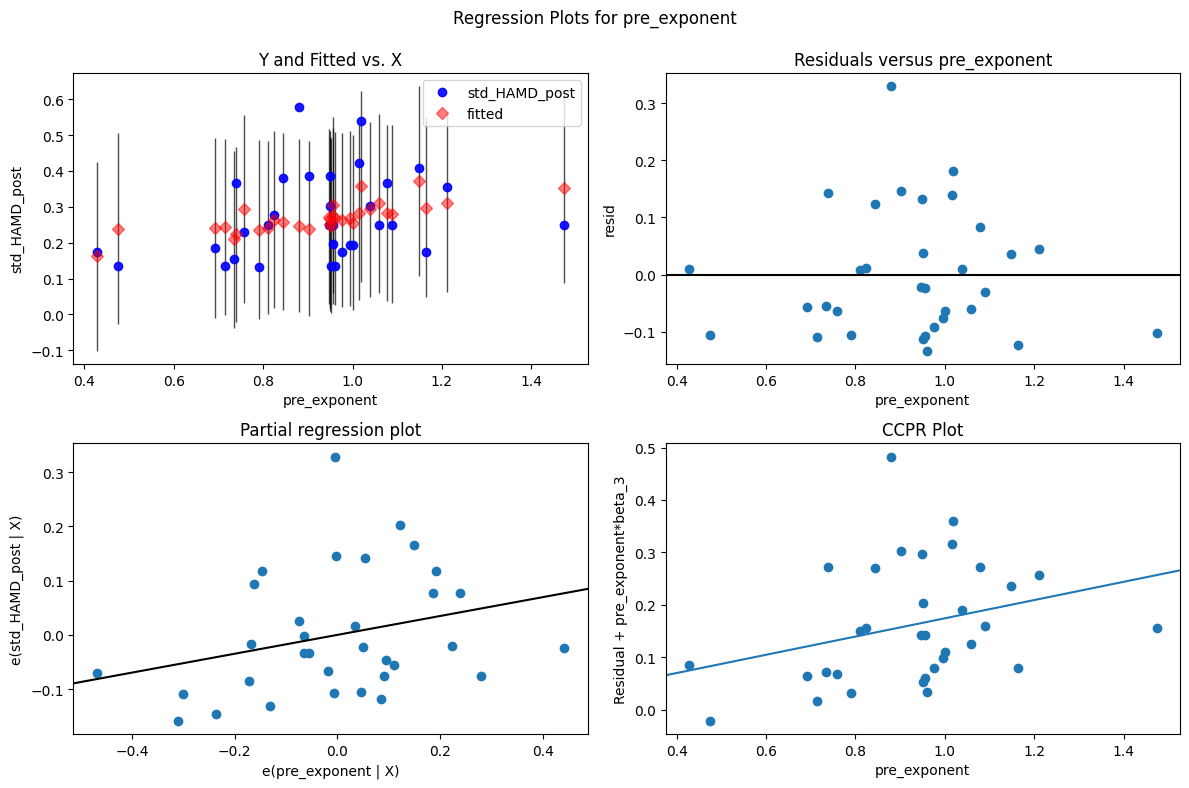

In [46]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'pre_exponent', fig=fig)

In [47]:
model.get_robustcov_results(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          std_HAMD_post   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     1.282
Date:                Thu, 22 Jun 2023   Prob (F-statistic):              0.299
Time:                        15:24:37   Log-Likelihood:                 26.720
No. Observations:                  33   AIC:                            -45.44
Df Residuals:                      29   BIC:                            -39.45
Df Model:                           3                                         
Covariance Type:                  HC3                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.0493      0.193     -0.255      0.800      -0.444       0.345
C(treatment_type)[T.MST]     0.0460      0.059      0.777      0.444      -0.075       0.167
std_HAMD_pre                 0.3244      0.337      0.963      0.344      -0.365       1.013
pre_exponent                 0.1741      0.099      1.749      0.091      -0.029       0.378
==============================================================================
Omnibus:                        7.605   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                6.193
Skew:                           1.010   Prob(JB):                       0.0452
Kurtosis:                       3.654   Cond. No.                         23.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

eval_env: 1


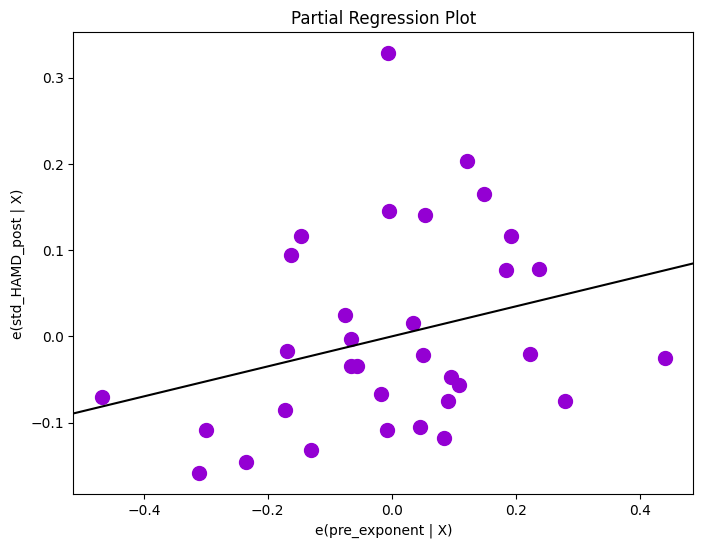

In [48]:
ect_mst_clin_eeg_df_nonan = pd.DataFrame(ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['std_HAMD_post'].notna()])

fig, ax = plt.subplots(figsize=(8,6))
fig, coords = sm.graphics.plot_partregress(endog="std_HAMD_post", exog_i="pre_exponent", exog_others=["std_HAMD_pre", 'C(treatment_type)'],
                             data=ect_mst_clin_eeg_df_nonan, obs_labels=False, color='darkviolet', ax=ax, markersize=10, ret_coords=True);


In [49]:
ect_mst_clin_eeg_df_nonan['coord_x'] = coords[0]
ect_mst_clin_eeg_df_nonan['coord_y'] = coords[1]

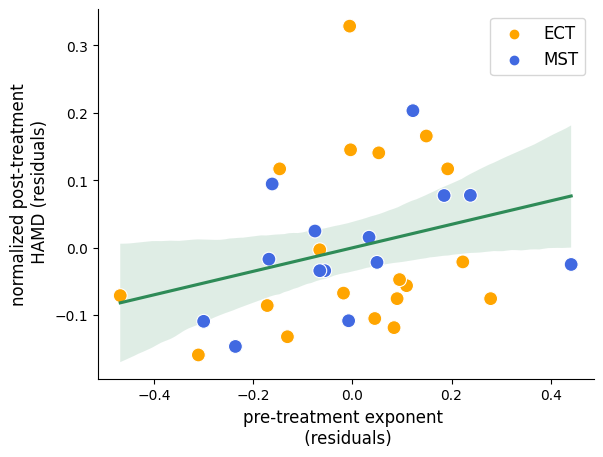

In [50]:
color_dict = {'ECT':'orange',
              'MST': 'royalblue'}

sns.regplot(data=ect_mst_clin_eeg_df_nonan, x='coord_x', y='coord_y', color='seagreen')
sns.scatterplot(data=ect_mst_clin_eeg_df_nonan, x='coord_x', y='coord_y', hue='treatment_type',
                palette=color_dict, s=100)

plt.xlabel('pre-treatment exponent \n (residuals)', size=12)
plt.ylabel('normalized post-treatment\n HAMD (residuals)', size=12)
# plt.title('', size=25)
ax.tick_params(axis='both', labelsize=20)
plt.legend(title='', fontsize=12)
sns.despine()
# plt.show()

# Difference in baseline exponent ECT & MST 

In [51]:
ttest(mst_clin_eeg_df['pre_exponent'], ect_clin_eeg_df['pre_exponent'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.71174,42,two-sided,0.094321,"[-0.02, 0.22]",0.516109,0.951,0.387061


In [52]:
sns.set_context('notebook')

Text(0.5, 0, 'baseline exponent')

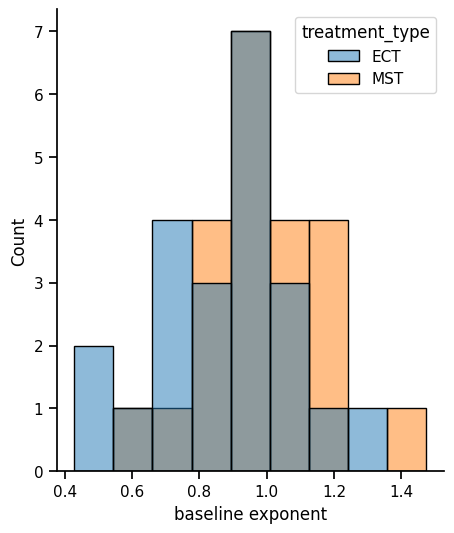

In [53]:
plt.figure(figsize=[5,6])
sns.histplot(ect_mst_clin_eeg_df, x='pre_exponent', hue='treatment_type')
sns.despine()
plt.xlabel('baseline exponent')

# Relationship between difference in exponent and number of treatments received

## ECT

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,n,r,CI95%,p-val,BF10,power
pearson,19,-0.536577,"[-0.8, -0.11]",0.017858,3.865,0.688058


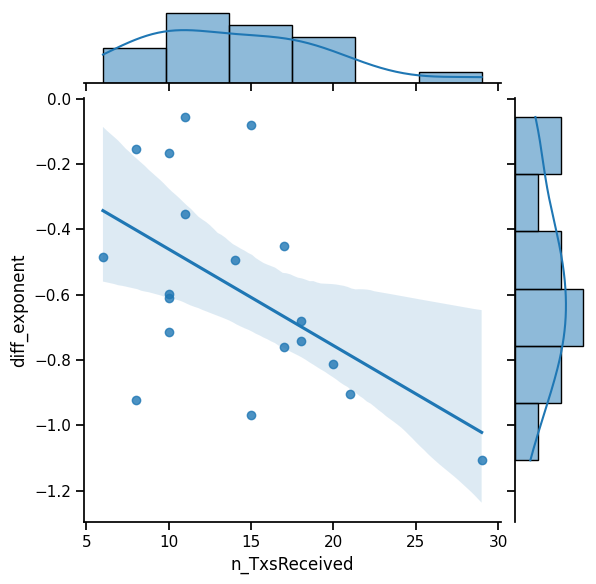

In [54]:
x = ect_clin_eeg_df['n_TxsReceived']
y = ect_clin_eeg_df['diff_exponent']

sns.jointplot(x, y, kind="reg")

corr(x,y)

## MST

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,n,r,CI95%,p-val,BF10,power
pearson,22,0.03592,"[-0.39, 0.45]",0.873908,0.267,0.052245


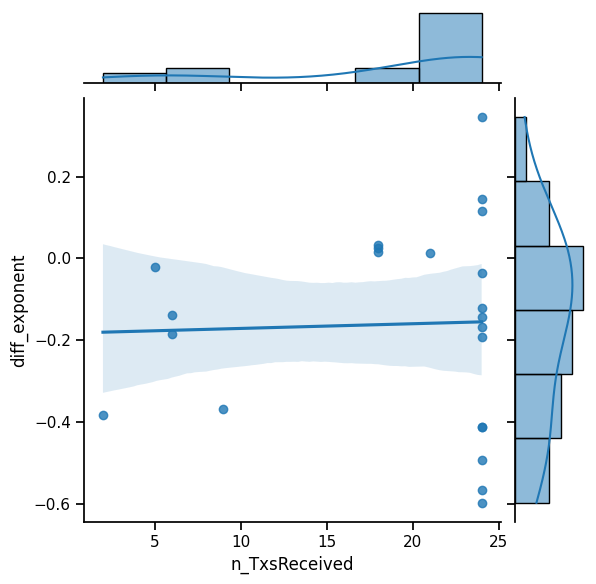

In [55]:
x = mst_clin_eeg_df['n_TxsReceived']
y = mst_clin_eeg_df['diff_exponent']

sns.jointplot(x, y, kind="reg")

corr(x,y)

In [56]:
ect_mst_clin_eeg_df[['patient', 'treatment_type', 'diff_theta_cf']]

,patient,treatment_type,diff_theta_cf
0,3,ECT,0.498191
1,4,ECT,0.728374
2,10,ECT,0.864910
3,13,ECT,-0.287061
4,16,ECT,0.826101
5,18,ECT,NaN
6,19,ECT,-0.479380
7,25,ECT,0.733550
8,29,ECT,-1.199892
9,31,ECT,0.692422


# exhaustive search for ECT

In [57]:
features = ['pre_exponent', 
            'pre_ch_delta_perc', 'pre_ch_theta_perc',
            'diff_exponent',
            'diff_ch_delta_perc', 'diff_ch_theta_perc', 'n_TxsReceived',
            'std_HAMD_pre']

In [58]:
ect_df = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='ECT']

In [59]:
nonan_df = ect_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_47718/3190535721.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  nonan_df = ect_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])


In [60]:
ect_dict = {'data': nonan_df[features].values,
                'target': nonan_df['std_HAMD_post'].values,
                'target_names': ['std_HAMD_post'],
                'feature_names': features}

In [61]:
ect_dict['data']

array([[ 4.75477798e-01,  1.83333333e-01,  6.33333333e-01,
        -9.21488482e-01, -2.83333333e-01, -2.83333333e-01,
         8.00000000e+00,  6.34615385e-01],
       [ 8.10114791e-01,  1.66666667e-02,  3.33333333e-02,
        -1.65960962e-01, -3.33333333e-02, -8.16666667e-01,
         1.00000000e+01,  4.61538462e-01],
       [ 9.02231662e-01,  1.83333333e-01,  7.00000000e-01,
        -3.53966413e-01,  1.16666667e-01, -2.83333333e-01,
         1.10000000e+01,  4.03846154e-01],
       [ 1.01503132e+00,  4.00000000e-01,  1.33333333e-01,
        -8.14528301e-02, -1.66666667e-02, -1.66666667e-01,
         1.50000000e+01,  4.80769231e-01],
       [ 8.80447150e-01,  0.00000000e+00,  0.00000000e+00,
        -4.51484510e-01, -5.00000000e-02, -4.66666667e-01,
         1.70000000e+01,  4.42307692e-01],
       [ 7.58157918e-01,  1.77777778e-01,  2.22222222e-02,
        -5.66554584e-02,  1.33333333e-01, -4.44444444e-02,
         1.10000000e+01,  6.53846154e-01],
       [ 1.16479093e+00,  6.000000

In [62]:
X = ect_dict['data']
y = ect_dict['target']

lr = LinearRegression()

efs = EFS(lr, 
          min_features=2,
          max_features=8,
          fixed_features=(7,),
          scoring='neg_mean_squared_error',
          cv=10)



efs.fit(X, y)

print('Best MSE score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)

Features: 127/127


Best subset: (3, 6, 7)


In [63]:
def adjust_r2(r2, num_examples, num_features):
    coef = (num_examples - 1) / (num_examples - num_features - 1) 
    return 1 - (1 - r2) * coef

In [64]:
for i in efs.subsets_:
    efs.subsets_[i]['adjusted_avg_score'] = (
        adjust_r2(r2=efs.subsets_[i]['avg_score'],
                  num_examples=X.shape[0]/10,
                  num_features=len(efs.subsets_[i]['feature_idx']))
    )

In [65]:
score = -99e10

for i in efs.subsets_:
    score = efs.subsets_[i]['adjusted_avg_score']
    if ( efs.subsets_[i]['adjusted_avg_score'] == score and
        len(efs.subsets_[i]['feature_idx']) < len(efs.best_idx_) )\
      or efs.subsets_[i]['adjusted_avg_score'] > score:
        efs.best_idx_ = efs.subsets_[i]['feature_idx']

In [66]:
print('Best adjusted R2 score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)



Best subset: (0, 7)


In [67]:
formula = 'std_HAMD_post ~ std_HAMD_pre + pre_exponent'

model = ols(formula, ect_df).fit()

print(model.summary())

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:          std_HAMD_post   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                 -0.056
Method:                 Least Squares   F-statistic:                    0.5231
Date:                Thu, 22 Jun 2023   Prob (F-statistic):              0.602
Time:                        15:24:40   Log-Likelihood:                 13.484
No. Observations:                  19   AIC:                            -20.97
Df Residuals:                      16   BIC:                            -18.13
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2360      0.294      0.802   

eval_env: 1


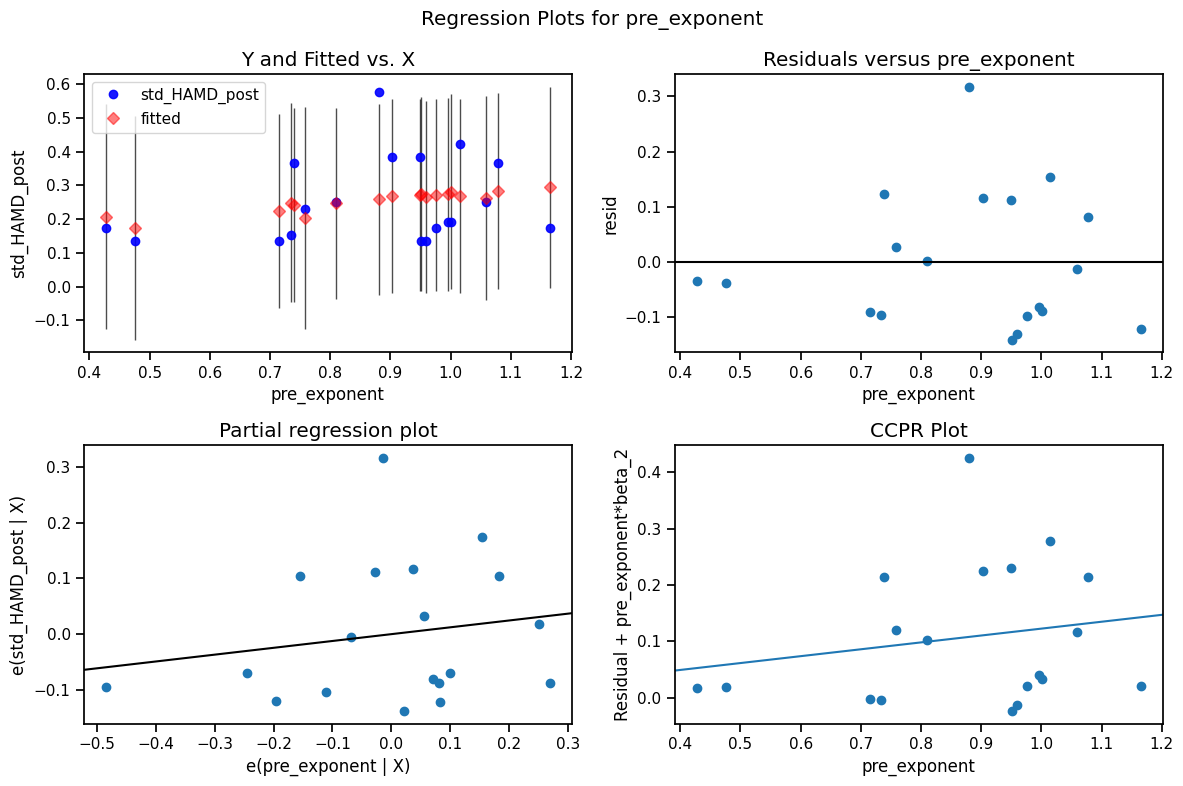

In [69]:
fig = plt.figure(figsize=(12,8))

fig = sm.graphics.plot_regress_exog(model, 'pre_exponent', fig=fig)

In [70]:
model.get_robustcov_results(cov_type='HC3').summary()

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          std_HAMD_post   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                 -0.056
Method:                 Least Squares   F-statistic:                     1.071
Date:                Thu, 22 Jun 2023   Prob (F-statistic):              0.366
Time:                        15:25:08   Log-Likelihood:                 13.484
No. Observations:                  19   AIC:                            -20.97
Df Residuals:                      16   BIC:                            -18.13
Df Model:                           2                                         
Covariance Type:                  HC3                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2360      0.204      1.160      0.263      -0.195       0.668
std_HAMD_pre    -0.1903      0.284     -0.671      0.512      -0.791       0.411
pre_exponent     0.1223      0.121      1.007      0.329      -0.135       0.380
==============================================================================
Omnibus:                        4.673   Durbin-Watson:                   1.418
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                2.912
Skew:                           0.947   Prob(JB):                        0.233
Kurtosis:                       3.302   Cond. No.                         25.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

# MST exhaustive search

In [71]:
features = ['pre_exponent', 
            'pre_ch_delta_perc', 'pre_ch_theta_perc',
            'diff_exponent',
            'diff_ch_delta_perc', 'diff_ch_theta_perc', 'n_TxsReceived',
            'std_HAMD_pre']

In [72]:
mst_df = ect_mst_clin_eeg_df[ect_mst_clin_eeg_df['treatment_type']=='MST']

In [73]:
nonan_df = mst_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_47718/2292353501.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  nonan_df = mst_df.dropna('rows', how='any', subset=['std_HAMD_post', 'n_TxsReceived'])


In [74]:
mst_dict = {'data': nonan_df[features].values,
                'target': nonan_df['std_HAMD_post'].values,
                'target_names': ['std_HAMD_post'],
                'feature_names': features}

In [75]:
mst_dict['data']

array([[ 1.47395333e+00,  3.33333333e-02,  5.00000000e-01,
         3.45649691e-01,  3.33333333e-02, -4.16666667e-01,
         2.40000000e+01,  3.02631579e-01],
       [ 1.21089730e+00,  1.66666667e-02,  3.83333333e-01,
         1.15917314e-01,  0.00000000e+00,  2.66666667e-01,
         2.40000000e+01,  3.15789474e-01],
       [ 9.56468488e-01,  0.00000000e+00,  6.33333333e-01,
        -4.94473489e-01, -1.33333333e-01, -2.66666667e-01,
         2.40000000e+01,  3.42105263e-01],
       [ 8.23412851e-01,  0.00000000e+00,  8.83333333e-01,
        -3.67107787e-02,  0.00000000e+00, -1.16666667e-01,
         2.40000000e+01,  3.81578947e-01],
       [ 1.14774092e+00,  2.33333333e-01,  3.33333333e-02,
         1.44388116e-01,  1.83333333e-01,  3.33333333e-02,
         2.40000000e+01,  5.39473684e-01],
       [ 9.46448719e-01,  0.00000000e+00,  6.66666667e-01,
        -4.13030142e-01, -1.00000000e-01, -3.00000000e-01,
         2.40000000e+01,  3.42105263e-01],
       [ 9.50434509e-01,  1.666666

In [ ]:
X = mst_dict['data']
y = mst_dict['target']

lr = LinearRegression()

efs = EFS(lr, 
          min_features=2,
          max_features=8,
          fixed_features=(7,),
          scoring='neg_mean_squared_error',
          cv=10)



efs.fit(X, y)

print('Best MSE score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)

Features: 24/127

In [ ]:
def adjust_r2(r2, num_examples, num_features):
    coef = (num_examples - 1) / (num_examples - num_features - 1) 
    return 1 - (1 - r2) * coef

In [ ]:
for i in efs.subsets_:
    efs.subsets_[i]['adjusted_avg_score'] = (
        adjust_r2(r2=efs.subsets_[i]['avg_score'],
                  num_examples=X.shape[0]/10,
                  num_features=len(efs.subsets_[i]['feature_idx']))
    )

In [ ]:
score = -99e10

for i in efs.subsets_:
    score = efs.subsets_[i]['adjusted_avg_score']
    if ( efs.subsets_[i]['adjusted_avg_score'] == score and
        len(efs.subsets_[i]['feature_idx']) < len(efs.best_idx_) )\
      or efs.subsets_[i]['adjusted_avg_score'] > score:
        efs.best_idx_ = efs.subsets_[i]['feature_idx']

In [ ]:
print('Best adjusted R2 score: %.2f' % efs.best_score_ * (-1))
print('Best subset:', efs.best_idx_)


In [ ]:
formula = 'std_HAMD_post ~ std_HAMD_pre + pre_exponent'

model = ols(formula, mst_df).fit()

print(model.summary())

# Pre- Post- Clinical scores

In [ ]:
def plot_feature_prepost(exp_df_mean, feature='', tx_type=''):
    """Creates a plot of a given feature from the dataframe,
       comparing its value before and after treatment

    Parameters
    ----------
    exp_df_mean: pandas DataFrame
        dataframe containing extractec features, averaged across electrodes
    feature: str
        feature of interest; 'alphas', 'thetas', 'chans_exps'
    tx_type: str
        treatment type (to determine color scheme); 'ECT', 'MST'

    Returns
    -------
    plot: matplotlib obj
        plot of feature pre/post treatment
    """
    
    pats = np.unique(exp_df_mean['patient'])
    
    if tx_type=='ECT':
        pre_color = 'orange'
        post_color = 'teal'
    elif tx_type=='MST':
        pre_color = 'royalblue'
        post_color = 'salmon'

    # means of alphas across patient, channels
    means_pre = exp_df_mean['pre_HAMD'].values
    means_post = exp_df_mean['post_HAMD'].values

    sns.set_context('poster')

    plt.figure(figsize=(5,8))
    x1, x2 = 0.5, 1.5

    for pat in pats:

        point_pre = exp_df_mean[(exp_df_mean['patient']==pat)]['pre_HAMD'].values
        point_post = exp_df_mean[(exp_df_mean['patient']==pat)]['post_HAMD'].values
        xdat1= x1+np.random.normal(0, 0.025, 1)
        xdat2= x2+np.random.normal(0, 0.025, 1)


        plt.plot([xdat1,xdat2], [point_pre, point_post], color='k', alpha=0.05, lw=5)
        plt.scatter(xdat1, point_pre, color=pre_color, alpha=0.7)
        plt.scatter(xdat2, point_post, color=post_color, alpha=0.7)

    plt.plot([x1-0.2, x1+0.2], [np.nanmean(means_pre), np.nanmean(means_pre)], lw=7, c=pre_color)
    plt.plot([x2-0.2, x2+0.2], [np.nanmean(means_post), np.nanmean(means_post)], lw=7, c=post_color)
            
    plt.xlim([0, 2])

    plt.xticks([x1, x2], ["pre", "post"])

#     if feature == 'alphas':
#         ylabel = 'Alpha Frequency (Hz)'
#     elif feature == 'thetas':
#         ylabel = 'Theta Frequency (Hz)'
#     elif feature == 'chans_exps':
#         ylabel = 'Aperiodic Exponent'
#     else:
#         ylabel = feature[:5]+' power'

#     plt.ylabel(ylabel)

    plt.tight_layout()


In [86]:
## ECT

ect_df_nonan = ect_mst_clin_eeg_df_nonan[ect_mst_clin_eeg_df_nonan['treatment_type']=='ECT']

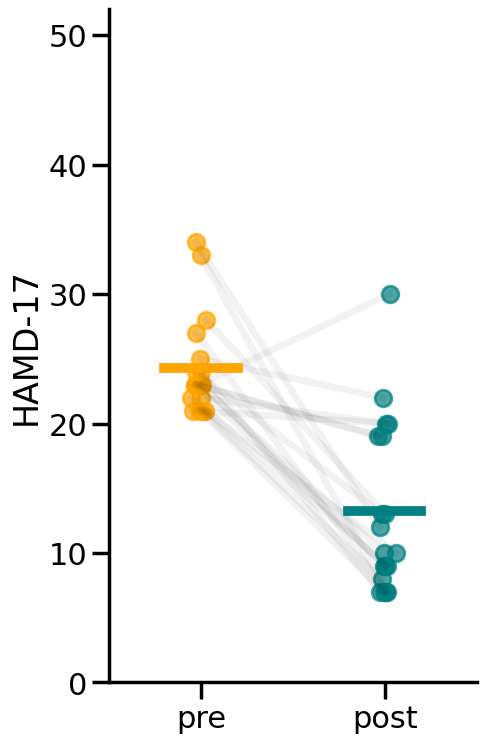

In [95]:
plot_feature_prepost(ect_df_nonan, feature='pre_HAMD', tx_type='ECT')
plt.ylabel('HAMD-17');
plt.ylim([0,52])
sns.despine()

In [89]:
ttest(x=ect_df_nonan['pre_HAMD'], y=ect_df_nonan['post_HAMD'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,5.93785,18,two-sided,0.000013,"[7.14, 14.96]",2.065479,1766.477,1.0


In [91]:
print('pre = '+ str(ect_df_nonan['pre_HAMD'].mean())\
      + ' std = ' + str(ect_df_nonan['pre_HAMD'].std()))

print('post = '+ str(ect_df_nonan['post_HAMD'].mean())\
      + ' std = ' + str(ect_df_nonan['post_HAMD'].std()))

pre = 24.263157894736842 std = 3.7689094394231732
post = 13.210526315789474 std = 6.562341616022448


In [115]:
normality(ect_df_nonan[['pre_HAMD', 'post_HAMD']])

,W,pval,normal
pre_HAMD,0.766256,0.000385,False
post_HAMD,0.849770,0.006651,False


In [105]:
wilcoxon(ect_df_nonan['pre_HAMD'], ect_df_nonan['post_HAMD'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,6.0,two-sided,0.000053,0.936842,0.939058


In [116]:
ect_df_nonan[['pre_HAMD', 'post_HAMD']].describe()

,pre_HAMD,post_HAMD
count,19.000000,19.000000
mean,24.263158,13.210526
std,3.768909,6.562342
min,21.000000,7.000000
25%,22.000000,8.500000
50%,23.000000,10.000000
75%,24.500000,19.000000
max,34.000000,30.000000


In [93]:
## MST

mst_df_nonan = ect_mst_clin_eeg_df_nonan[ect_mst_clin_eeg_df_nonan['treatment_type']=='MST']

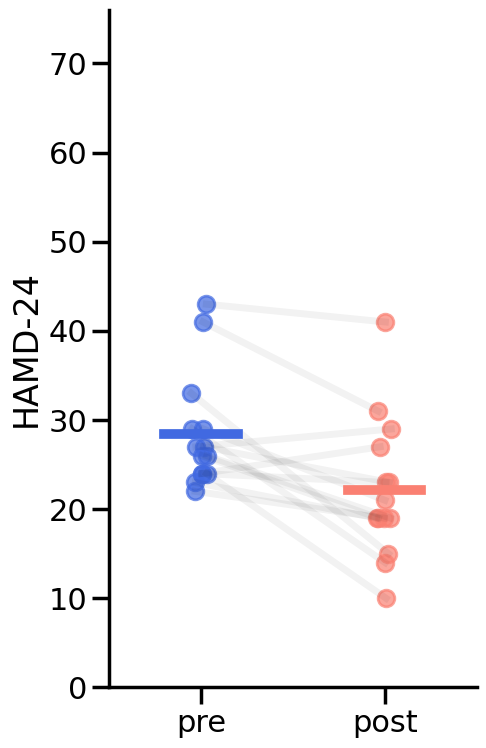

In [96]:
plot_feature_prepost(mst_df_nonan, feature='pre_HAMD', tx_type='MST')
plt.ylabel('HAMD-24');
plt.ylim([0,76])
sns.despine()

In [97]:
ttest(x=mst_df_nonan['pre_HAMD'], y=mst_df_nonan['post_HAMD'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.744485,13,two-sided,0.002453,"[2.66, 9.91]",0.872594,18.277,0.85458


In [107]:
normality(mst_df_nonan[['pre_HAMD', 'post_HAMD']])

,W,pval,normal
pre_HAMD,0.807431,0.006176,False
post_HAMD,0.940928,0.430341,True


In [108]:
wilcoxon(mst_df_nonan['pre_HAMD'], mst_df_nonan['post_HAMD'])

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,7.0,two-sided,0.002319,0.866667,0.772959


In [111]:
mst_df_nonan[['pre_HAMD', 'post_HAMD']].describe()

,pre_HAMD,post_HAMD
count,14.000000,14.000000
mean,28.428571,22.142857
std,6.429670,7.901871
min,22.000000,10.000000
25%,24.000000,19.000000
50%,26.500000,20.000000
75%,29.000000,26.000000
max,43.000000,41.000000
